In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.table import Table
from toolbox.image import img_scale
from matplotlib.patches import Ellipse
el = Ellipse((2, -1), 0.5, 0.5)
pixscale = 0.168 # arcsec/pixel
plt.style.use('jpg')
cmap = plt.cm.rainbow
figDIR = '../../figures/gemini_FT_6-2016/'
datDIR = '../../data/gemini_FT_6-2016/'

In [2]:
c6files = [d for d in os.listdir(datDIR+'candy_6_cutout') if d[-4:]=='fits']
c6files[1], c6files[2] = c6files[2], c6files[1]
c6files.reverse() # imshow expects RGB
c7files = [d for d in os.listdir(datDIR+'candy_7_cutout') if d[-4:]=='fits']
c7files[1], c7files[2] = c7files[2], c7files[1]
c7files.reverse()
prof6 = {}
prof7 = {}
for band in 'gri':
    prof6.update({band:np.loadtxt(datDIR+'candy_6_cutout/candy_6_prof_'+band+'.dat')})
    prof7.update({band:np.loadtxt(datDIR+'candy_7_cutout/candy_7_prof_'+band+'.dat')})
fitparams = [(4.862,0.0,3.402), (7.5, 0.0, 3.998)]
# distances in Mpc (c6, c7_close, c7_far)
D_A_vals = [125.741, 21.283, 306.706]
D_L_vals = [133.519, 21.497, 356.855]

In [3]:
# rough gaussian and 1D sersic fits to SB profiles
gauss = {}
sersic = {}
fitter = fitting.LevMarLSQFitter()

for band in 'gri':
    gparams = [(5., 0., 3.), (5., 0., 4.)]
    sparams = [(5., 6., 0.9), (5., 8., 0.9)]
    for i, prof in enumerate([prof6[band], prof7[band]]):
        _a, _m, _s = gparams[i]
        gauss_init = models.Gaussian1D(amplitude=_a, mean=_m, stddev=_s)
        x = np.concatenate([-prof[:,0], prof[:,0]])
        y = np.concatenate([prof[:,1], prof[:,1]])
        gauss.update({(band,i):fitter(gauss_init, x, y)})
        _a, _r, _n = sparams[i]
        sersic_init = models.Sersic1D(amplitude=_a, r_eff=_r, n=_n)
        sersic.update({(band,i):fitter(sersic_init, prof[:,0], prof[:,1])})

# Color images

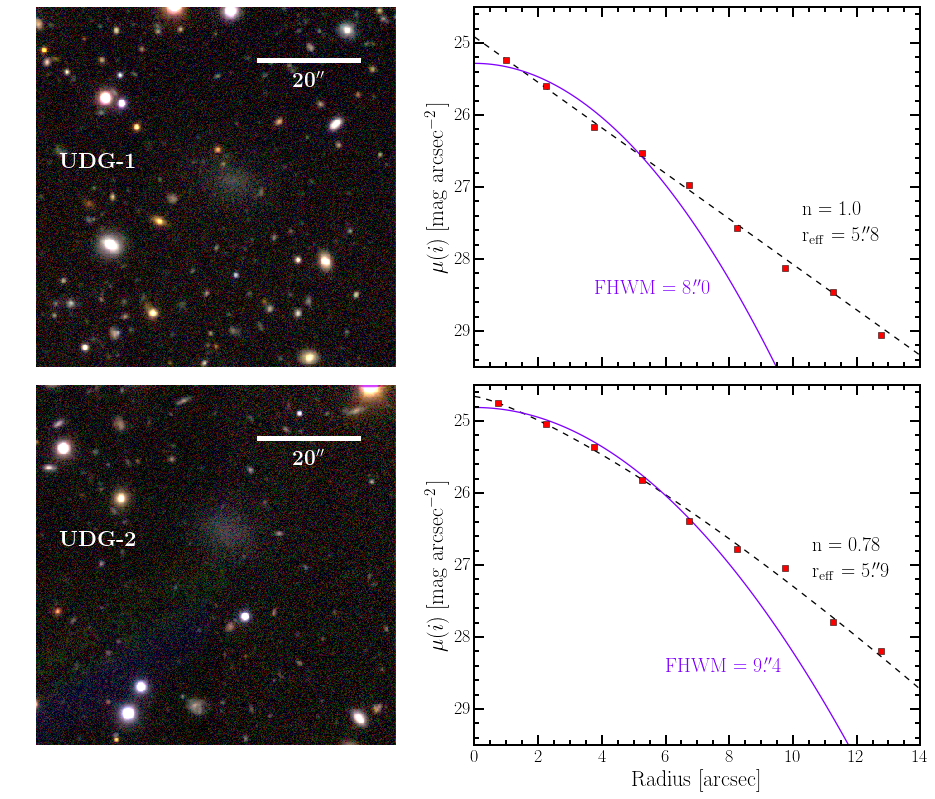

In [4]:
c6 = np.zeros((444, 437, 3))
c7 = np.zeros((451, 463, 3))
c6_max_vals = [0.5, 1.2, 1.9]
c7_max_vals = [0.7, 2.0, 1.2]
min_val = 0.0
for i in range(len(c6files)-1):
    c6_data = fits.getdata(datDIR+'candy_6_cutout/'+c6files[i])
    c7_data = fits.getdata(datDIR+'candy_7_cutout/'+c7files[i])
    max_val = c6_data.mean() + c6_max_vals[i]*c6_data.std()
    c6[:,:,i] = img_scale.sqrt(c6_data, scale_min=min_val, scale_max=max_val)
    max_val = c7_data.mean() + c7_max_vals[i]*c7_data.std()
    c7[:,:,i] = img_scale.sqrt(c7_data, scale_min=min_val, scale_max=max_val)
f, ax = plt.subplots(2, 2, figsize=(16, 12.5))
f.subplots_adjust(hspace=0.05, wspace=0.08)
c6 = c6[:435, :435, :] 
c7 = c7[:435, :435, :] 
y = 370.
xmin = 270.
xmax = xmin + 119
theta = np.linspace(0,14,100)
for i, c, p in zip(range(2), [c6, c7], [prof6, prof7]):
    ax[i,0].imshow(c, aspect='equal', origin='lower', rasterized=True)
    ax[i,0].axhline(y=y, xmin=xmin/c.shape[1], 
                  xmax=xmax/c.shape[1], color='w', lw=5, zorder=10)
    ax[i,0].text(0.5*(xmin+xmax), y-31.5, r'${\bf 20^{\prime\prime}}$', 
                 color='w',fontsize=21, ha='center')
    ax[i,0].text(28, 240, r'\textbf{UDG-'+str(i+1)+'}', 
                 fontsize=22, color='w', fontweight='bold')
    ax[i,0].axis('off')
    ax[i,1].plot(theta, 27 - 2.5*np.log10(sersic[('i',i)](theta)), 'k--', lw=1.3)
    line, = ax[i,1].plot(theta, 27 - 2.5*np.log10(gauss[('i',i)](theta)), lw=1.3, c=cmap(0))
    fwhm = str(round(2.355*gauss[('i',i)].stddev.value, 1))
    ax[i,1].text(3.8+i*2.2, 28.5, 'FHWM = '+fwhm[0]+r'$.\!^{\prime\prime}$'+fwhm[2:], 
                 color=line.get_color(), fontsize=20)
    _a, _r, _n = sersic[('i',i)].param_sets
    reff = str(round(_r[0], 1))
    ax[i,1].text(10.3+i*0.3, 27.4-i*0.58, 'n = {:.2}'.format(_n[0]), fontsize=20, ha='left')
    ax[i,1].text(10.3+i*0.3, 27.8-i*0.58, r'r$_\mathrm{eff}$ = '+reff[0]+'$.\!^{\prime\prime}$'+reff[2:], 
                 fontsize=20, ha='left')
    ax[i,1].plot(p['i'][:-1,0], 27 - 2.5*np.log10(p['i'][:-1,1]), 's', c=cmap(1.0))
    ax[i,1].set_ylim(24.5, 29.5)
    ax[i,1].invert_yaxis()
    ax[i,1].minorticks_on()
    ax[i,1].set_ylabel(r'$\mu(i)$ [mag arcsec$^{-2}\,$]')
ax[1,1].set_xlabel('Radius [arcsec]')
plt.setp(ax[0,1].get_xticklabels(), visible=False)
f.savefig(figDIR+'UDG_candidates+profiles.pdf');

# Monochromatic images

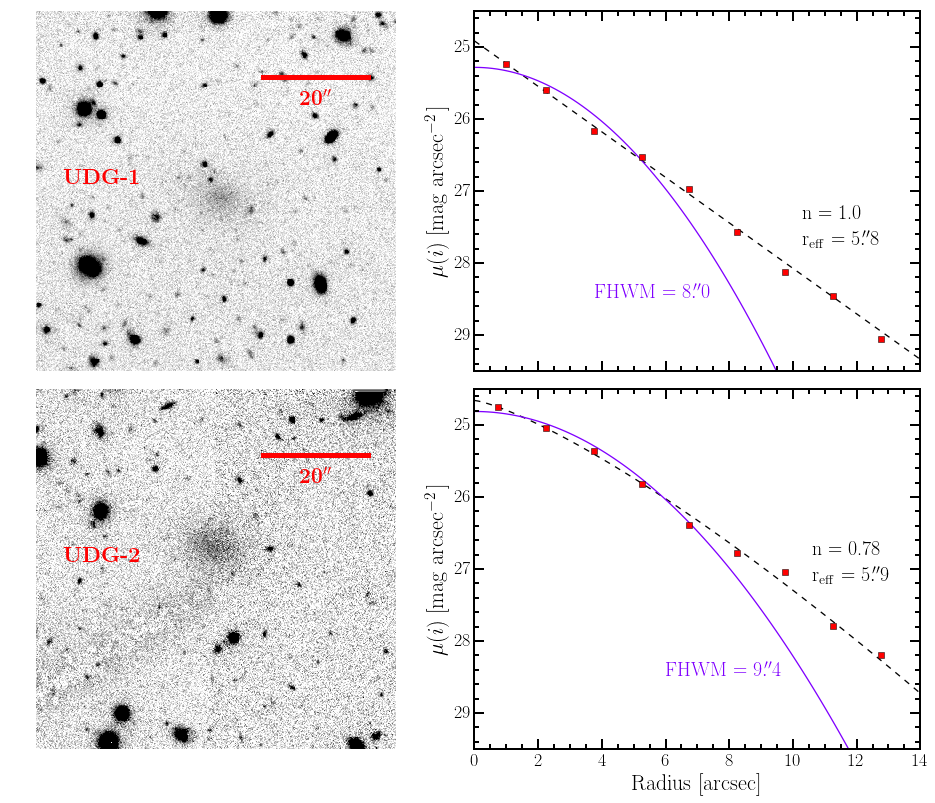

In [5]:
band = 'i'
c6 = np.zeros((444, 437, 4))
c7 = np.zeros((451, 463, 4))
vmin, vmax = -0.05, 0.5
color_dict = {'z':0, 'i':1, 'r':2, 'g':3}
label_color = cmap(1.0)
c6 = fits.getdata(datDIR+'candy_6_cutout/'+c6files[color_dict[band]])
c7= fits.getdata(datDIR+'candy_7_cutout/'+c7files[color_dict[band]])
dpix = 30
c6 = c6[dpix:435, dpix:435] 
c7 = c7[dpix:435, dpix:435] 
f, ax = plt.subplots(2, 2, figsize=(16, 12.5))
f.subplots_adjust(hspace=0.05, wspace=0.08)
y = 330.
xmin = 255.
xmax = xmin + 119
theta = np.linspace(0,14,100)
for i, c, p in zip(range(2), [c6, c7], [prof6[band], prof7[band]]):
    ax[i,0].imshow(c, aspect='equal', origin='lower', rasterized=True, vmin=vmin, vmax=vmax, cmap='gray_r')
    ax[i,0].axhline(y=y, xmin=xmin/c.shape[1], 
                  xmax=xmax/c.shape[1], color=label_color, lw=5, zorder=10)
    ax[i,0].text(0.5*(xmin+xmax), y-30.5, r'${\bf 20^{\prime\prime}}$', 
                 color=label_color,fontsize=21, ha='center')
    ax[i,0].text(30, 210, r'\textbf{UDG-'+str(i+1)+'}', 
                 fontsize=22, color=label_color, fontweight='bold')
    ax[i,0].axis('off')
    ax[i,1].plot(theta, 27 - 2.5*np.log10(sersic[(band,i)](theta)), 'k--', lw=1.3)
    line, = ax[i,1].plot(theta, 27 - 2.5*np.log10(gauss[(band,i)](theta)), lw=1.3, c=cmap(0))
    fwhm = str(round(2.355*gauss[(band,i)].stddev.value, 1))
    ax[i,1].text(3.8+i*2.2, 28.5, 'FHWM = '+fwhm[0]+r'$.\!^{\prime\prime}$'+fwhm[2:], 
                 color=line.get_color(), fontsize=20)
    _a, _r, _n = sersic[(band,i)].param_sets
    reff = str(round(_r[0], 1))
    ax[i,1].text(10.3+i*0.3, 27.4-i*0.58, 'n = {:.2}'.format(_n[0]), fontsize=20, ha='left')
    ax[i,1].text(10.3+i*0.3, 27.8-i*0.58, r'r$_\mathrm{eff}$ = '+reff[0]+'$.\!^{\prime\prime}$'+reff[2:], 
                 fontsize=20, ha='left')
    ax[i,1].plot(p[:-1,0], 27 - 2.5*np.log10(p[:-1,1]), 's', c=cmap(1.0))
    ax[i,1].set_ylim(24.5, 29.5)
    ax[i,1].invert_yaxis()
    ax[i,1].minorticks_on()
    ax[i,1].set_ylabel(r'$\mu(i)$ [mag arcsec$^{-2}\,$]')
ax[1,1].set_xlabel('Radius [arcsec]')
plt.setp(ax[0,1].get_xticklabels(), visible=False)
f.savefig(figDIR+'UDG_candidates+profiles_HSC-I.pdf');

In [6]:
vanDokkum = Table.read(datDIR+'vanDokkum2015_Table_1.txt', format='ascii')
brodie = np.genfromtxt(datDIR+'sizetable.txt', names=('id', 'host', 'M_V', 'logr', 'ref'), dtype='S10,S10,f8,f8,S10')
brodie = brodie[brodie['ref']!='vD+15']
coma_dm = 35.05
mihos_MV = [-15.0, -13.5, -14.9]
mihos_reff = [9.7, 2.9, 5.5]
imags = [20.3, 19.7]
reff_vals = []
Mi_vals = []
for i, D_A, D_L in zip([0,1,1], D_A_vals, D_L_vals):
    reff_vals.append(D_A*1e3*sersic[('i',i)].r_eff.value*u.arcsec.to('radian'))
    Mi_vals.append(imags[i] - 5*np.log10(D_L*1e6) + 5)

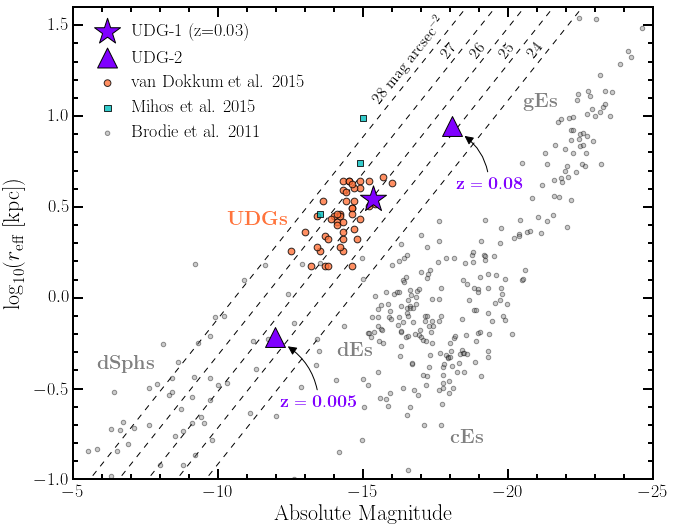

In [7]:
f, a = plt.subplots(figsize=(10,8))

# plot lines of constant effective surface brightness
reff_kpc = np.linspace(0.001,100,100)
reff_10pc_as = u.radian.to('arcsec')*1e3*reff_kpc/10.0
for sb in [24, 25, 26, 27, 28]:
    absmag = sb-2.5*np.log10(2*np.pi*reff_10pc_as**2)
    a.plot(absmag, np.log10(reff_kpc), 'k--', zorder=-200)
    
# plot my candidates
scale = 2.2
a.scatter(Mi_vals[0], np.log10(reff_vals[0]), marker='*',
          s=340*scale, c=cmap(0), zorder=100, label='UDG-1 (z=0.03)')
a.scatter(Mi_vals[1:], np.log10(reff_vals[1:]), marker='^',
          s=180*scale, c=cmap(0), zorder=100, label='UDG-2') 
a.annotate(r'${\bf z=0.005}$', xy=(Mi_vals[1]-.38, np.log10(reff_vals[1])-0.047), 
           xytext=(-14.8,-.6),color=cmap(0), fontsize=15, ha='right',size=18,
           arrowprops=dict(arrowstyle="-|>", fc='k', ec="k", patchB=el,
           connectionstyle="arc3,rad=0.25"))
a.annotate(r'${\bf z=0.08}$', xy=(Mi_vals[2]-.38, np.log10(reff_vals[2])-0.047), 
           xytext=(-20.5,0.6),color=cmap(0), fontsize=15, ha='right',size=18,
           arrowprops=dict(arrowstyle="-|>", fc='k', ec="k", patchB=el,
           connectionstyle="arc3,rad=0.25"))

# plot van Dokkum and Mihos
a.scatter(vanDokkum['Mg'], np.log10(vanDokkum['reff']), marker='o', s=45, edgecolors='k',
          alpha=0.8, color=cmap(0.85), label='van Dokkum et al. 2015')
a.scatter(mihos_MV, np.log10(mihos_reff), marker='s', s=42, c='c', alpha=0.8, label='Mihos et al. 2015')
a.scatter(brodie['M_V'], brodie['logr']+np.log10(1e-3), c='gray', alpha=0.4,
          zorder=-10, label='Brodie et al. 2011')
a.set_ylim(-1, 1.6)
a.set_xlim(-25,-5)
a.set_ylabel(r'$\log_{10}(r_\mathrm{eff}\ [\mathrm{kpc}])$')
a.set_xlabel(r'Absolute Magnitude')
a.minorticks_on()
a.invert_xaxis()
a.legend(loc='upper left', fontsize=18)

# get text rotation angle 
p1 = a.transData.transform_point((absmag[0], np.log10(reff_kpc)[0])) # convert from data 
p2 = a.transData.transform_point((absmag[1], np.log10(reff_kpc)[1])) # to screen coords
rot = np.degrees(np.arctan2(p2[1]-p1[1], p2[0]-p1[0]))

# add text to figure
x, dx, y = -17.6, -1, 1.3
fs = 15.5
a.text(-15.2, 1.05, r'28 mag arcsec$^{-2}$',rotation=rot, fontsize=fs, va='bottom')
a.text(x, y, '27',rotation=rot, fontsize=fs, va='bottom')
a.text(x+dx, y, '26',rotation=rot, fontsize=fs, va='bottom')
a.text(x+2*dx, y, '25',rotation=rot, fontsize=fs, va='bottom')
a.text(x+3*dx, y, '24',rotation=rot,fontsize=fs, va='bottom') 

a.text(-5.8, -.4, r'${\bf dSphs}$', color='gray', fontsize=20)
a.text(-10.3, .4, r'${\bf UDGs}$', color=cmap(0.85), fontsize=20)
a.text(-20.5, 1.05, r'${\bf gEs}$', color='gray', fontsize=20)
a.text(-18, -.8, r'${\bf cEs}$', color='gray', fontsize=20)
a.text(-14.1, -0.32, r'${\bf dEs}$', color='gray', fontsize=20)

f.savefig(figDIR+'size_vs_absmag.pdf');

## Average effective surface brightness at 6$^{\prime\prime}$

In [8]:
print(np.array(imags) + 2.5*np.log10(2*np.pi*6**2))

[ 26.18620592  25.58620592]
